In [1]:
import sys
sys.path.append('../../../GraphGallery/')
sys.path.append('../../../GraphAdv/')

import tensorflow as tf
import numpy as np
import networkx as nx
import scipy.sparse as sp

from graphgallery.nn.models import GCN
from graphgallery.nn.functions import softmax
from graphadv.attack.targeted import IGA


import matplotlib.pyplot as plt
plt.style.use(['no-latex', 'ieee'])

In [2]:
from graphgallery.data import NPZDataset
data = NPZDataset('citeseer', root="~/GraphData/datasets/", verbose=False, standardize=True)
adj, x, labels = data.graph.unpack()
idx_train, idx_val, idx_test = data.split(random_state=15)

n_classes = labels.max() + 1

Downloaded dataset files have existed.
Processing...
Processing completed.


In [3]:
target = 0
assert target in idx_test
print(f"Attack target {target} with class label {labels[target]}")

Attack target 0 with class label 1


In [4]:
attacker = IGA(adj, x, labels, idx_train, seed=None, surrogate_args={'idx_val':idx_val})
attacker.reset()
attacker.attack(target, direct_attack=True, structure_attack=True, feature_attack=False)
# show logs
attacker.show_edge_flips(detail=True)

=== IGA: Train a surrogate model `DenseGCN` from scratch ===


Peturbing Graph: 100%|██████████| 11/11 [00:03<00:00,  3.19it/s]

Add an edge (0   <-> 252), class 0  = 1, class 252= 2.
Add an edge (0   <-> 1582), class 0  = 1, class 1582= 2.
Add an edge (0   <-> 1133), class 0  = 1, class 1133= 0.
Add an edge (0   <-> 153), class 0  = 1, class 153= 2.
Add an edge (285 <-> 687), class 285= 1, class 687= 2.
Add an edge (0   <-> 374), class 0  = 1, class 374= 2.
Add an edge (0   <-> 2095), class 0  = 1, class 2095= 2.
Add an edge (0   <-> 2074), class 0  = 1, class 2074= 2.
Add an edge (0   <-> 681), class 0  = 1, class 681= 2.
Add an edge (0   <-> 671), class 0  = 1, class 671= 2.
Add an edge (0   <-> 1583), class 0  = 1, class 1583= 2.
Flip 11 edges, 11 added, 0 removed. Added edges with different classes: 100.00%, removed edges with the same classes: 0.00%


# Before Attack

In [5]:
model = GCN(adj, x, labels, device='GPU', norm_x=None, seed=42)
model.build()
his = model.train(idx_train, idx_val, verbose=1, epochs=100)
softmax(model.predict(target).ravel())

<Loss = 0.1372 Acc = 0.9953 Val_Loss = 1.1586 Val_Acc = 0.7393 >: 100%|██████████| 100/100 [00:02<00:00, 48.92it/s]


array([0.00338119, 0.9180413 , 0.02703149, 0.00751557, 0.02036829,
       0.02366217], dtype=float32)

# After Attack

In [6]:
model = GCN(attacker.A, x, labels, device='GPU', norm_x=None, seed=42)
model.build()
his = model.train(idx_train, idx_val, verbose=1, epochs=100)
softmax(model.predict(target).ravel())

<Loss = 0.1374 Acc = 0.9953 Val_Loss = 1.1492 Val_Acc = 0.7393 >: 100%|██████████| 100/100 [00:01<00:00, 54.86it/s]


array([1.2807607e-06, 7.3784203e-03, 9.9260569e-01, 1.0418311e-06,
       8.8001516e-06, 4.7342637e-06], dtype=float32)

#  Visulation

In [7]:
def evaluate(adj, x, retrain_iters=5):
    
    classification_margins = []
    class_distrs = []
    for _ in range(retrain_iters):
        print(f"... {_+1}/{retrain_iters} ")
        model = GCN(adj, x, labels, device='GPU', norm_x=None, seed=None)
        model.build()
        his = model.train(idx_train, idx_val, verbose=0, epochs=100)
        logit = softmax(model.predict(target).ravel())
            
        class_distrs.append(logit)
        best_second_class_before = (logit - labels[target]).argmax()
        margin = logit[labels[target]] - logit[best_second_class_before]
        classification_margins.append(margin)
        model.close
        del model
        
    class_distrs = np.array(class_distrs)
    return class_distrs

In [8]:
retrain_iters = 5
print("Before Attack")
class_distrs_clean = evaluate(adj, x, retrain_iters=retrain_iters)
print(f"After {attacker.name} Attack")
class_distrs_retrain = evaluate(attacker.A, x, retrain_iters=retrain_iters)

Before Attack
... 1/5 
... 2/5 
... 3/5 
... 4/5 
... 5/5 
After IGA Attack
... 1/5 
... 2/5 
... 3/5 
... 4/5 
... 5/5 


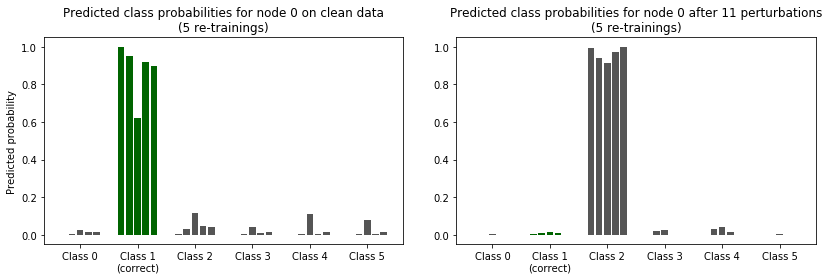

In [9]:
def make_xlabel(ix, correct):
    if ix == correct:
        return "Class {}\n(correct)".format(ix)
    return "Class {}".format(ix)


figure = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
center_ixs_clean = []
for ix, block in enumerate(class_distrs_clean.T):
    x_ixs = np.arange(len(block)) + ix*(len(block)+2)
    center_ixs_clean.append(np.mean(x_ixs))
    color = '#555555'
    if ix == labels[target]:
        color = 'darkgreen'
    plt.bar(x_ixs, block, color=color)

ax = plt.gca()
plt.ylim((-.05, 1.05))
plt.ylabel("Predicted probability")
ax.set_xticks(center_ixs_clean)
ax.set_xticklabels([make_xlabel(k, labels[target]) for k in range(n_classes)])
ax.set_title(f"Predicted class probabilities for node {target} on clean data\n({retrain_iters} re-trainings)")

fig = plt.subplot(1, 2, 2)
center_ixs_retrain = []
for ix, block in enumerate(class_distrs_retrain.T):
    x_ixs = np.arange(len(block)) + ix*(len(block)+2)
    center_ixs_retrain.append(np.mean(x_ixs))
    color = '#555555'
    if ix == labels[target]:
        color = 'darkgreen'
    plt.bar(x_ixs, block, color=color)


ax = plt.gca()
plt.ylim((-.05, 1.05))
ax.set_xticks(center_ixs_retrain)
ax.set_xticklabels([make_xlabel(k, labels[target]) for k in range(n_classes)])
ax.set_title(f"Predicted class probabilities for node {target} after {attacker.n_perturbations} perturbations\n({retrain_iters} re-trainings)")
plt.tight_layout()
plt.show()